# MoRu Phase Prediction using GPyTorch Gaussian Process Classifier

In [3]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt


/Users/bajpp/miniforge/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read and Dump JSON

In [4]:
import json

filename = '../data/MoRu_sparse.json'
stream = open(filename)
data = json.load(stream)
stream.close()


### Generate Dataset from JSON Dump

The dataset $\mathcal{D} \subset \mathbb{R}_{\ge 0}^{n_\text{samples} \times (n_\text{elements} + n_\text{phases} + 2)}$ is defined as:
$$\mathcal{D} = \{\mathbf{x}_i \, | \, i \in \{1, \dots, n_\text{samples}\}\}$$
where, $\mathbf{x}_i$ is a single sample such that:
$$\mathbf{x}_i = \left\{{T, P, \{c_j \, | \, j \in \mathcal{1, \dots, n_\text{elements}}\}, \{n_\phi \, | \, \phi \in \mathcal{1, \dots, n_\text{phases}}\}}\right\}$$
where, $c_j$ denotes number of moles of element $j$ and $n_\phi$ denotes the number of moles of phase $\phi$.

In [5]:
n_data = len(data)
n_elements = len(data['2']['elements'])
n_phases = len(data['2']['solution phases']) + len(data['2']['pure condensed phases'])
dataset = np.zeros((n_data, n_elements + n_phases + 2))

phase_names = list(data['2']['solution phases'].keys())
phase_names += list(data['2']['pure condensed phases'].keys())
element_names = list(data['2']['elements'].keys())


In [6]:
keys = list(data.keys())
for i in keys:
    dataset[keys.index(i), 0] = data[i]["temperature"]
    dataset[keys.index(i), 1] = data[i]["pressure"]

    for j in range(n_elements):
        if not (data[i]['elements'].get(element_names[j]) is None):
            dataset[keys.index(i), 2 + j] = data[i]["elements"][element_names[j]]["moles"]
        else:
            dataset[keys.index(i), 2 + j] = 0.0

    for j in range(n_phases):
        if not (data[i]['solution phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + n_elements + j] = data[i]["solution phases"][phase_names[j]]["moles"]
        elif not (data[i]['pure condensed phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + n_elements + j] = data[i]["pure condensed phases"][phase_names[j]]["moles"]
        else:
            dataset[keys.index(i), 2 + n_elements + j]


### Filter out zero phases

In [7]:
moles_cutoff = 1e-8
non_zero_columns = np.any(np.greater(dataset[:,(2 + n_elements):], moles_cutoff), axis=0)


In [8]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")


else:
    mps_device = torch.device("mps")


### Generate Training Data

- Training samples $n_\text{Train} = 0.6 * n_\text{Total}$
- Input $\mathbf{X} = {T, P, \mathbf{c}}$
- Output $\mathbf{y} = {\mathbf{n}_\phi}$

In [30]:
n_training = int(n_data * 0.6)

choice = np.random.choice(range(dataset.shape[0]), size=(n_training,), replace=False)
train_indices = np.zeros(dataset.shape[0], dtype=bool)
train_indices[choice] = True
test_indices = ~train_indices

train = dataset[train_indices]
test = dataset[test_indices]


In [31]:
# X_train = train[:,0:(2 + n_elements)]
X_train = train[:,0:(2 + n_elements)][:,(0,2)]                                  # Only T, Mo

# Change the outputs to 0.0 / 1.0 based on the number of moles of phase
# y_train = (train[:,(2 + n_elements):] > 0.0).astype(float)
y_train = (train[:,(2 + n_elements):][:,non_zero_columns] > 0.0).astype(float)  # Only non-zero phases

# Use the original moles
# y_train = train[:,(2 + n_elements):]
# y_train = train[:,(2 + n_elements):][:,non_zero_columns]                        # Only non-zero phases


In [32]:
# Convert to Torch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32, device=mps_device)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train_unscaled = X_train.detach().clone()
# y_train = torch.tensor(y_train, dtype=torch.float32, device=mps_device)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train_unscaled = y_train.detach().clone()


In [33]:
# Calculate mean and standard deviation of inputs
X_mean = X_train.mean(0,keepdim=True)
X_std = X_train.std(0,keepdim=True)

# Standard deviation of pressure is equal to 0.0. Change this to 1.0 to avoid division by zero when scaling
X_std[X_std == 0] = 1.0

# Scale inputs to mean 0 and standard deviation 1 for better convergence
X_train = (X_train - X_mean) / X_std


### Test Data

In [34]:
# Scale test input values to mean 0 and standard deviation 1 based on values from before
# X_test_unscaled = torch.tensor(test[:,0:(2 + n_elements)], dtype=torch.float32)
X_test_unscaled = torch.tensor(test[:,0:(2 + n_elements)][:,(0,2)], dtype=torch.float32)      # Only T, Mo
# X_test_unscaled = torch.tensor(test[:,0:(2 + n_elements)][:,(0,2)], dtype=torch.float32, device=mps_device)      # Only T, Mo
X_test = (X_test_unscaled - X_mean) / X_std

# 0 / 1 Output case
# y_test = (test[:,(2 + n_elements):] > 0.0).astype(float)
y_test = (test[:,(2 + n_elements):][:,non_zero_columns] > 0.0).astype(float)                  # Only non-zero phases

# Original moles of phase
# y_test = test[:,(2 + n_elements):]
# y_test = test[:,(2 + n_elements):][:,non_zero_columns]                                      # Only non-zero phases
y_test = torch.tensor(y_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32, device=mps_device)

# Combined test and training data
X_all_unscaled = torch.cat([X_train_unscaled, X_test_unscaled])
X_all = torch.cat([X_train, X_test])
y_all = torch.cat([y_train, y_test])


### Input Space Mapping

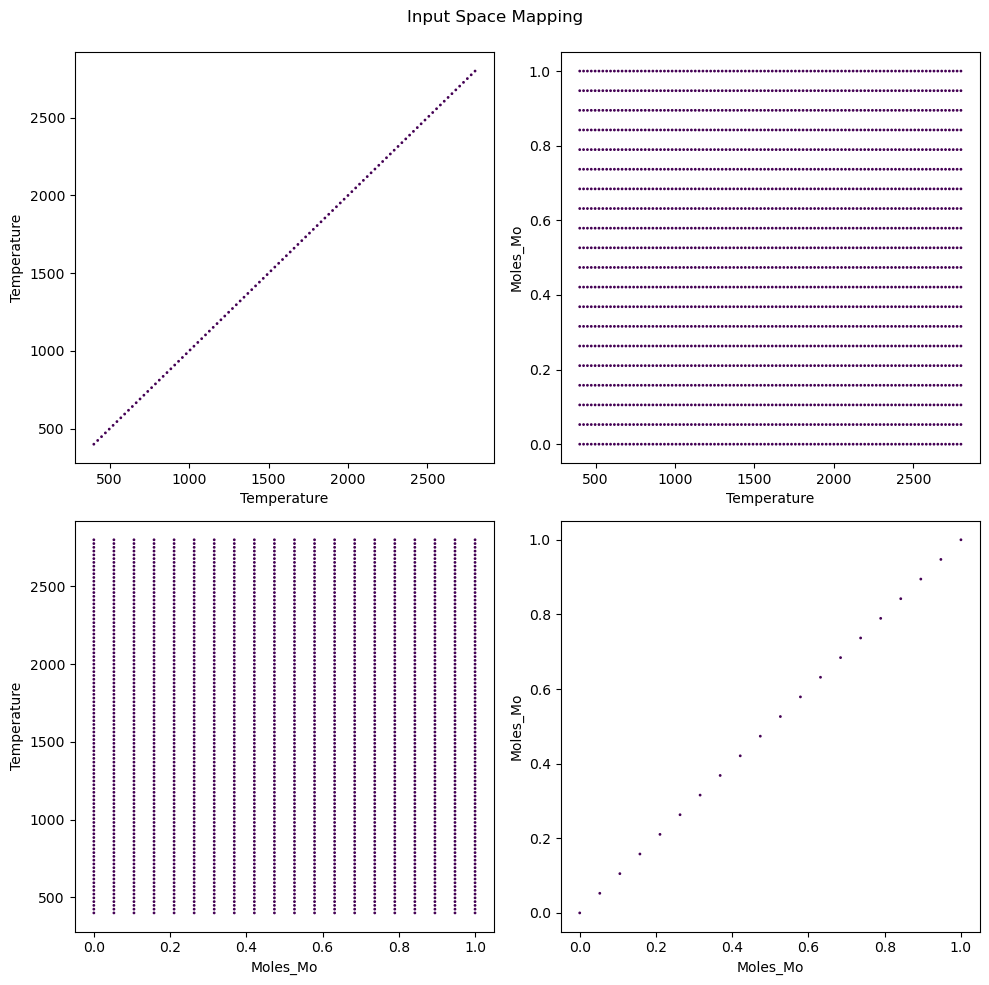

In [35]:
labels = ['Temperature', 'Moles_Mo']
n_columns = len(labels)

fig, ax = plt.subplots(nrows=n_columns, ncols=n_columns, figsize=(10, 10))

for i in range(n_columns):
  for j in range(n_columns):
    reduced, counts = np.unique(np.transpose(np.array([X_all_unscaled[:,i], X_all_unscaled[:,j]])), axis=0, return_counts=True)
    rx, ry = np.transpose(reduced)

    ax[i][j].scatter(rx, ry, c=counts, s=1)
    ax[i][j].set_xlabel(labels[i])
    ax[i][j].set_ylabel(labels[j])

fig.suptitle('Input Space Mapping\n')
fig.tight_layout()


### Softmax Normalization

Applies the Softmax function to output phase moles and rescales the moles to probabilities:
$$\text{Softmax}(x_i) = \frac{\exp{(x_i)}}{\sum_j \exp{(x_j)}}$$

In [36]:
normalization = torch.nn.Softmax(dim=1)
y_train_normalized = normalization(y_train)
y_test_normalized = normalization(y_test)


### Multitask Model

In [37]:
class MultiTaskGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(MultiTaskGPModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.MultitaskMean(gpytorch.means.ConstantMean(), num_tasks=train_y.shape[1])
    self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.RBFKernel(), num_tasks=train_y.shape[1], rank=1)

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=4)
# model = MultiTaskGPModel(X_train, y_train_normalized, likelihood)                 # With softmax normalization
model = MultiTaskGPModel(X_train, y_train, likelihood)                            # Without softmax normalization
# model = MultiTaskGPModel(X_train, y_train, likelihood)
# model.to(mps_device)


### Training

In [38]:
training_iterations = 500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    # loss = -mll(output, y_train_normalized)             # With softmax normalization
    loss = -mll(output, y_train)             # Without softmax normalization
    loss.backward()
    print(f'Finished iteration {i+1}/{training_iterations} - Loss: {loss.item()}')
    optimizer.step()


Finished iteration 1/500 - Loss: 1.132115125656128
Finished iteration 2/500 - Loss: 1.128294825553894
Finished iteration 3/500 - Loss: 1.1244717836380005
Finished iteration 4/500 - Loss: 1.1206461191177368
Finished iteration 5/500 - Loss: 1.1168177127838135
Finished iteration 6/500 - Loss: 1.1129863262176514
Finished iteration 7/500 - Loss: 1.1091519594192505
Finished iteration 8/500 - Loss: 1.1053146123886108
Finished iteration 9/500 - Loss: 1.1014740467071533
Finished iteration 10/500 - Loss: 1.097630262374878
Finished iteration 11/500 - Loss: 1.0937831401824951
Finished iteration 12/500 - Loss: 1.089932918548584
Finished iteration 13/500 - Loss: 1.0860791206359863
Finished iteration 14/500 - Loss: 1.0822217464447021
Finished iteration 15/500 - Loss: 1.078360915184021
Finished iteration 16/500 - Loss: 1.0744962692260742
Finished iteration 17/500 - Loss: 1.0706278085708618
Finished iteration 18/500 - Loss: 1.0667556524276733
Finished iteration 19/500 - Loss: 1.0628795623779297
Finishe

### Evaluation

In [39]:
# Set to eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions = likelihood(model(X_all))
  means = predictions.mean
  lower, upper = predictions.confidence_region()


/Users/bajpp/miniforge/envs/ML/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1715641618216/work/torch/csrc/utils/tensor_new.cpp:623.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


### Error Analysis

In [40]:
sorted_indices = (-means).numpy().argsort()
errors = np.zeros(y_all.shape)

for i in range(y_all.shape[0]):
  for j in range(y_all.shape[1]):
    if(y_all[i,j] > 0.0):                           # Present in full thermochemistry solve
      if(j in sorted_indices[i,(0,1)]):             # Present in surrogate (No error)
        errors[i,j] = 0.0
      else:                                         # Absent in surrogate (Hard error)
        errors[i,j] = 1.0
    else:                                           # Present in full thermochemistry solve
      if(j in sorted_indices[i,(0,1)]):
        errors[i,j] = 0.5                           # Present in surrogate (Soft error)
      else:
        errors[i,j] = 0.0                           # Absent in surrogate ()

errors_combined = np.max(errors, axis=1)
errors_combined_indices = np.argmax(errors, axis=1)

print(f"NN accuracy (hard error): {np.count_nonzero(errors_combined == 1.0) / errors_combined.shape[0]}")
print(f"NN accuracy (hard + soft error): {np.count_nonzero(errors_combined > 0.0) / errors_combined.shape[0]}")


NN accuracy (hard error): 0.0035
NN accuracy (hard + soft error): 0.6


In [41]:
means.shape

torch.Size([2000, 4])

### Plots

#### Predictions

In [66]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions = likelihood(model(X_all))
  means = predictions.mean
  lower, upper = predictions.confidence_region()

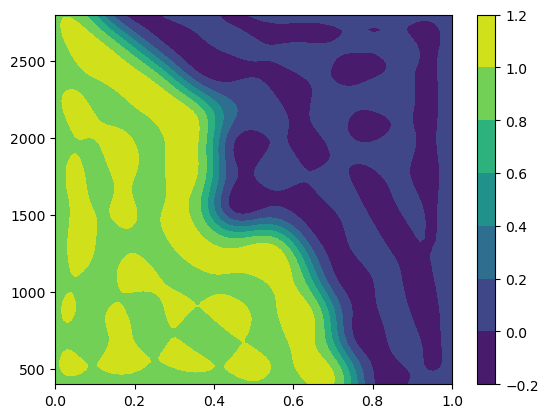

In [77]:
x_plot = np.linspace(0,1,100)
y_plot = np.linspace(400,2800,100)

xx, yy = np.meshgrid(x_plot, y_plot)
zz_means = np.zeros(xx.shape).flatten()

# xx_tensor = torch.tensor(xx.flatten(), dtype=torch.float32)
# yy_tensor = torch.tensor(yy.flatten(), dtype=torch.float32)
# print(xx_tensor.shape)
# print(yy_tensor.shape)



X_plot = np.column_stack([yy.flatten(), xx.flatten()])

X_plot_mean = X_plot.mean(0)
X_plot_std = X_plot.std(0)
# torch.tensor(X_plot, dtype=torch.float32)

X_mean = X_train.mean(0,keepdim=True)
X_std = X_train.std(0,keepdim=True)

X_plot = (X_plot - X_plot_mean) / X_plot_std

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions = likelihood(model(torch.tensor(X_plot, dtype=torch.float32)))
  zz_means = predictions.mean
  lower, upper = predictions.confidence_region()





h = plt.contourf(xx, yy, zz)
plt.colorbar()
plt.show()

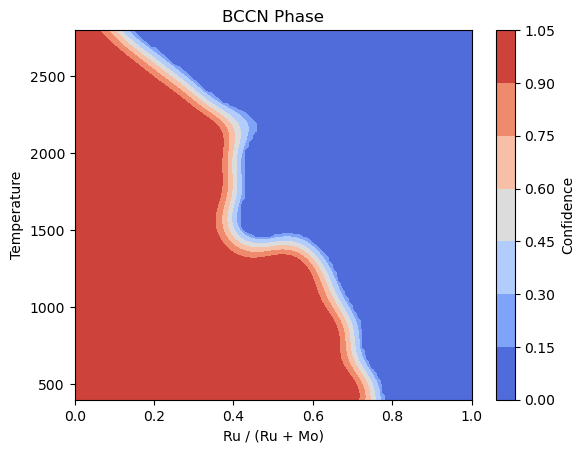

In [111]:
zz = zz_means[:,0].reshape(xx.shape).numpy()
mask = zz >= 0.3

zz_plot = np.where(zz > 0.2, zz, 0.0)
zz_plot = np.where(zz_plot < 1.0, zz_plot, 1.0)

h = plt.contourf(xx, yy, zz_plot, cmap='coolwarm')
# h = plt.contourf(xx, yy, zz_plot, cmap='bone')
plt.colorbar(label='Confidence')
plt.ylabel('Temperature')
plt.xlabel('Ru / (Ru + Mo)')
plt.title('BCCN Phase')
plt.show()

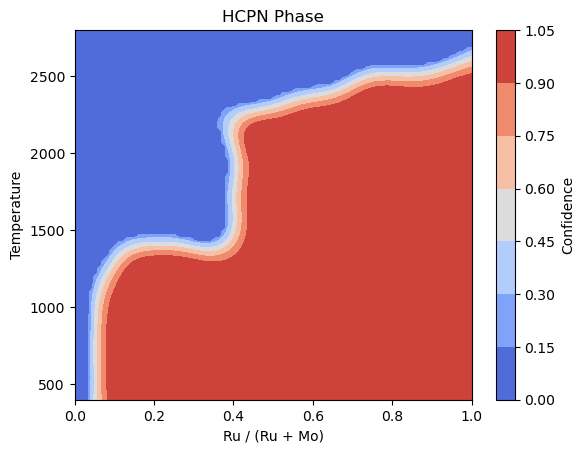

In [114]:
zz = zz_means[:,1].reshape(xx.shape).numpy()

mask = zz >= 0.3

zz_plot = np.where(zz > 0.2, zz, 0.0)
zz_plot = np.where(zz_plot < 1.0, zz_plot, 1.0)

h = plt.contourf(xx, yy, zz_plot, cmap='coolwarm')
plt.colorbar(label='Confidence')
plt.ylabel('Temperature')
plt.xlabel('Ru / (Ru + Mo)')
plt.title('HCPN Phase')
plt.show()

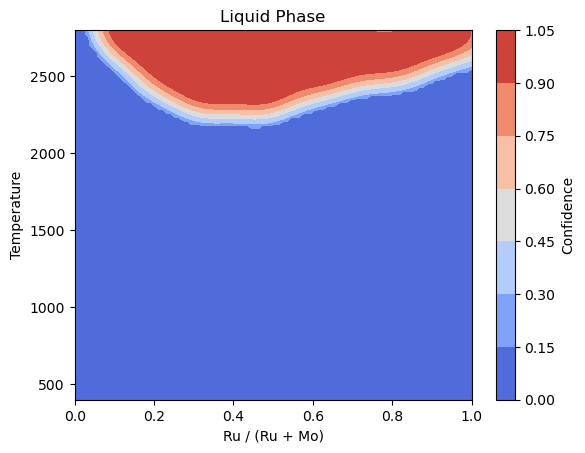

In [113]:
zz = zz_means[:,2].reshape(xx.shape).numpy()

mask = zz >= 0.3

zz_plot = np.where(zz > 0.2, zz, 0.0)
zz_plot = np.where(zz_plot < 1.0, zz_plot, 1.0)

h = plt.contourf(xx, yy, zz_plot, cmap='coolwarm')
plt.colorbar(label='Confidence')
plt.ylabel('Temperature')
plt.xlabel('Ru / (Ru + Mo)')
plt.title('Liquid Phase')
plt.show()

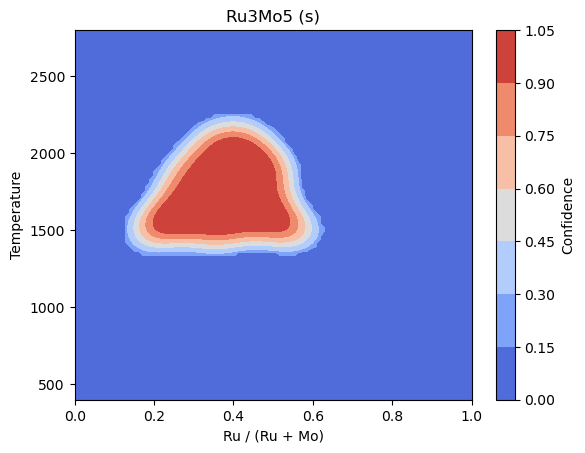

In [112]:
zz = zz_means[:,3].reshape(xx.shape).numpy()

mask = zz >= 0.3

zz_plot = np.where(zz > 0.2, zz, 0.0)
zz_plot = np.where(zz_plot < 1.0, zz_plot, 1.0)

h = plt.contourf(xx, yy, zz_plot, cmap='coolwarm')
plt.colorbar(label='Confidence')
plt.ylabel('Temperature')
plt.xlabel('Ru / (Ru + Mo)')
plt.title('Ru3Mo5 (s)')
plt.show()

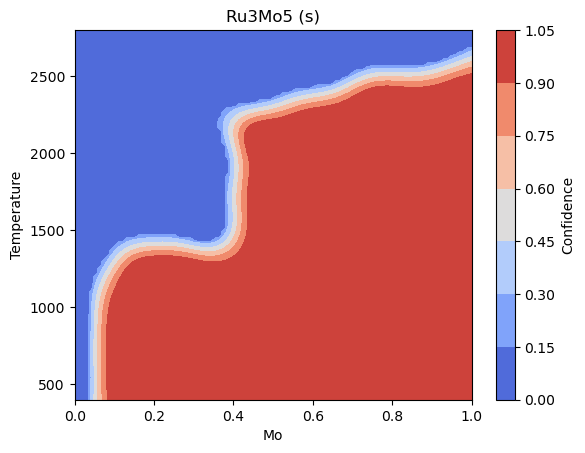

In [109]:
zz = zz_means[:,3].reshape(xx.shape).numpy()

mask = zz >= 0.3

zz_plot = np.where(zz > 0.2, zz, 0.0)
zz_plot = np.where(zz_plot < 1.0, zz_plot, 1.0)

h = plt.contourf(xx, yy, zz_plot, cmap='coolwarm')
plt.colorbar(label='Confidence')
plt.ylabel('Temperature')
plt.xlabel('Mo')
plt.title('Ru3Mo5 (s)')
plt.show()

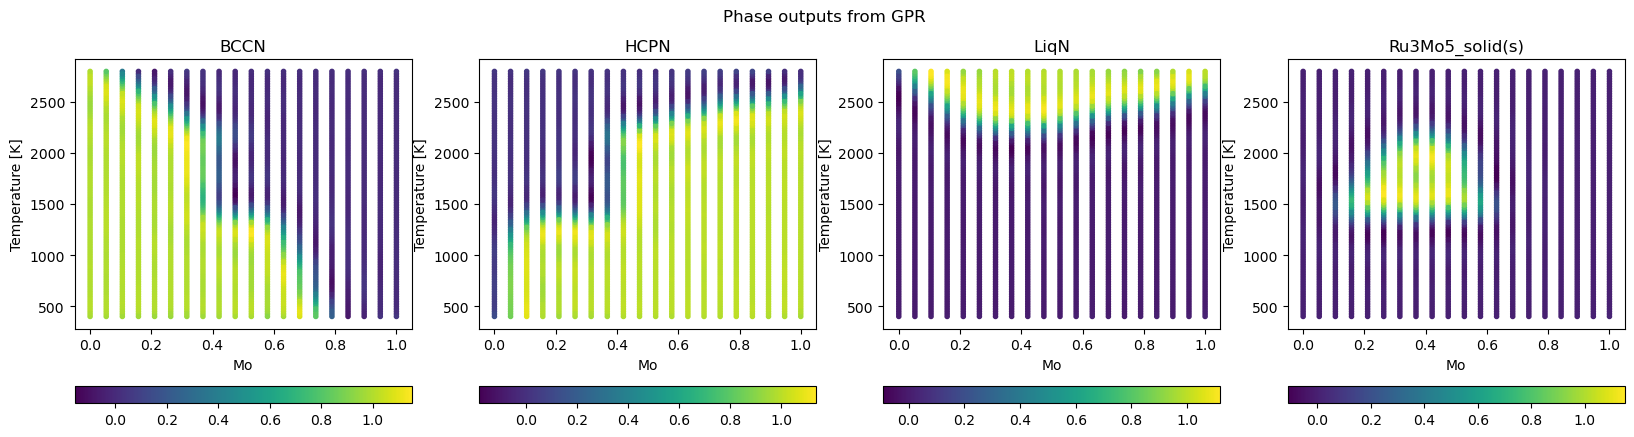

In [67]:
from itertools import compress

active_phases = list(compress(phase_names, non_zero_columns))

fig, axs = plt.subplots(nrows=1, ncols=len(active_phases), figsize=(20,5))



for i in range(len(active_phases)):
  ax  = axs[i]
  ax.set_xlabel('Mo')
  ax.set_ylabel('Temperature [K]')
  ax.set_title(active_phases[i])
  scatter = ax.scatter(X_all_unscaled[:,1].numpy(),
                       X_all_unscaled[:,0].numpy(),
                       c=(means[:,i]).numpy(), marker='.',
                       cmap='viridis')
  fig.colorbar(scatter, orientation='horizontal', ax=ax)
  fig.suptitle('Phase outputs from GPR')


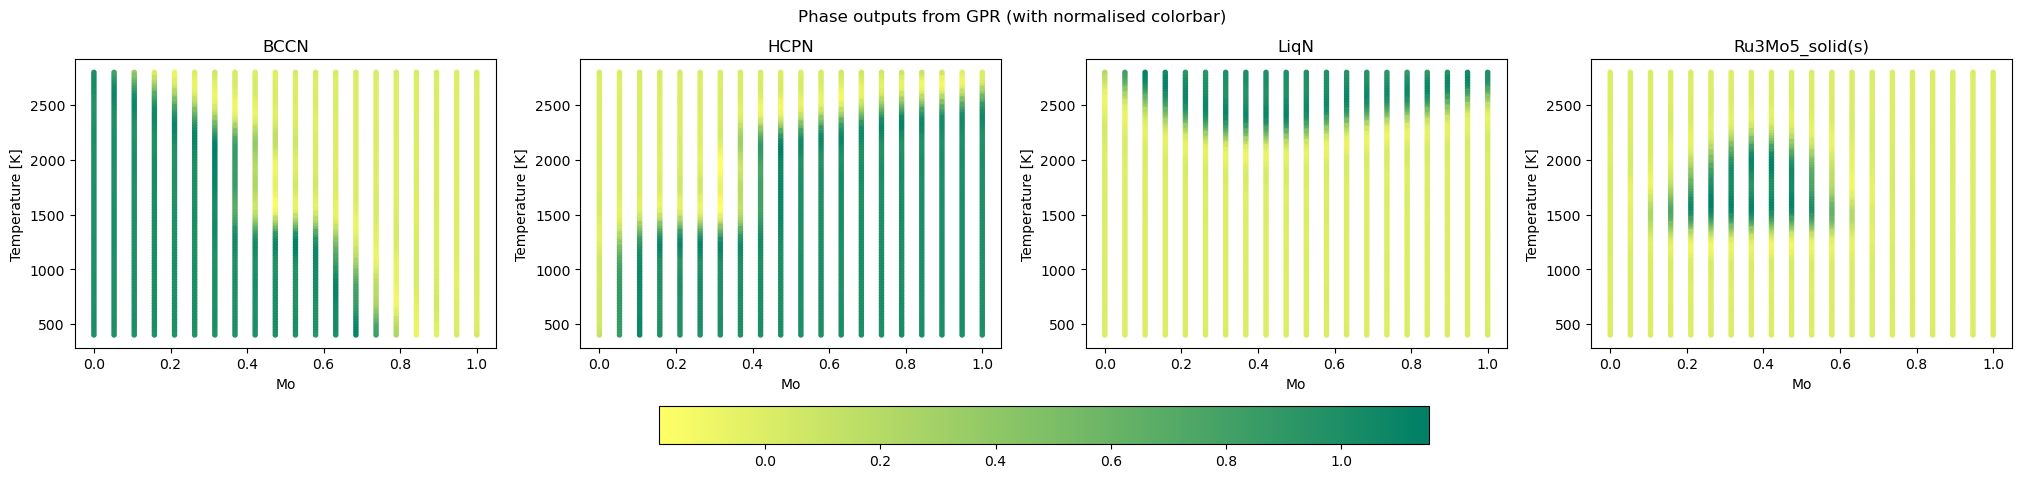

In [45]:
from matplotlib import colors

fig, axs = plt.subplots(nrows=1, ncols=len(active_phases), figsize=(25,5))
scatters = []

for i in range(len(active_phases)):
  axs[i].set_xlabel('Mo')
  axs[i].set_ylabel('Temperature [K]')
  axs[i].set_title(active_phases[i])
  scatters.append(axs[i].scatter(X_all_unscaled[:,1].numpy(), X_all_unscaled[:,0].numpy(),
                                 c=(means[:,i]).numpy(),
                                 marker='.',
                                 cmap='summer_r'))

# Find the min and max of all colors for use in setting the color scale.
vmin = min(scatter.get_array().min() for scatter in scatters)
vmax = max(scatter.get_array().max() for scatter in scatters)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for sc in scatters:
    sc.set_norm(norm)

fig.colorbar(scatters[0], ax=axs, orientation='horizontal', fraction=.1)
fig.suptitle('Phase outputs from GPR (with normalised colorbar)')

# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_scatter):
    for sc in scatters:
        if (changed_scatter.get_cmap() != sc.get_cmap()
                or changed_scatter.get_clim() != sc.get_clim()):
            sc.set_cmap(changed_scatter.get_cmap())
            sc.set_clim(changed_scatter.get_clim())

for sc in scatters:
    sc.callbacks.connect('changed', update)


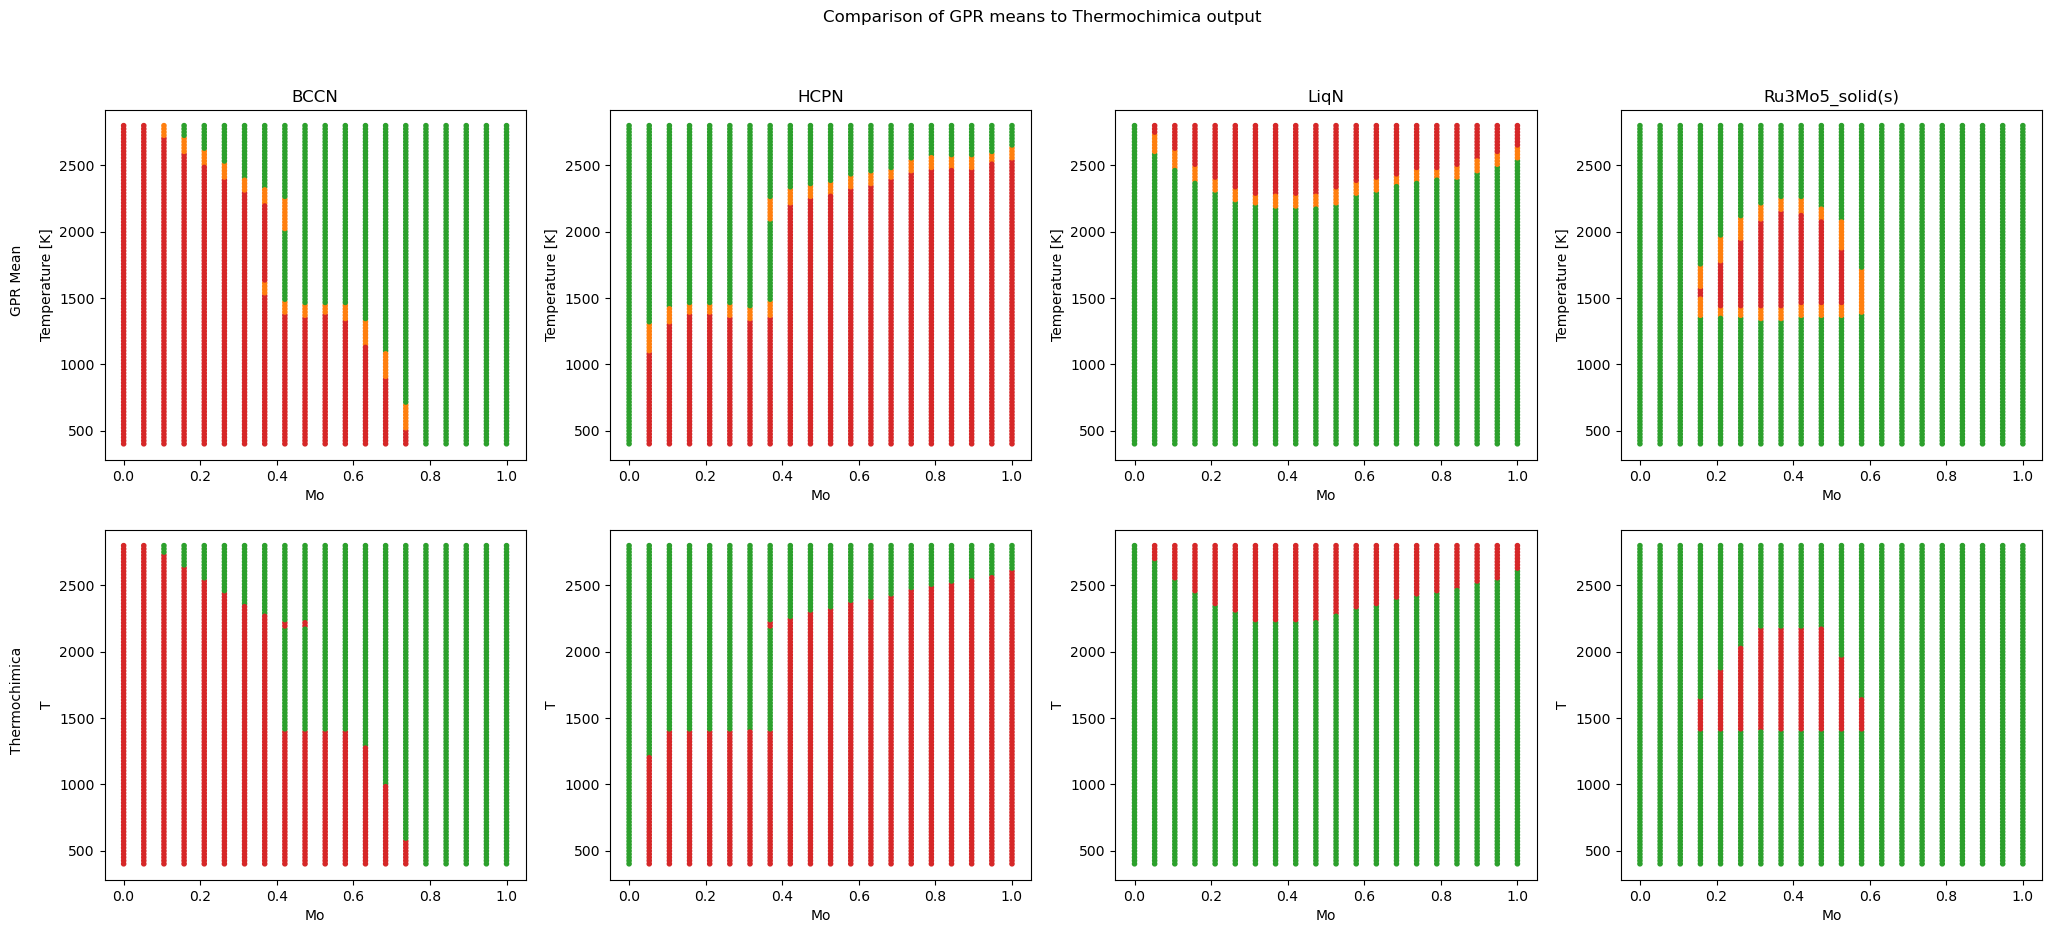

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=len(active_phases), figsize=(25,10))
scatters_model = []
scatters_thermochimica = []

for i in range(len(active_phases)):
  axs[0,i].set_xlabel('Mo')
  axs[0,i].set_ylabel('Temperature [K]')
  axs[0,i].set_title(active_phases[i])
  scatters_model.append(axs[0,i].scatter(X_all_unscaled[:,1].numpy(), X_all_unscaled[:,0].numpy(),
                                 c=means[:,i],
                                 marker='.',
                                 cmap=colors.ListedColormap(['tab:green', 'tab:orange' ,'tab:red'])))

  axs[1,i].set_xlabel('Mo')
  axs[1,i].set_ylabel('T')
  scatters_thermochimica.append(axs[1,i].scatter(X_all_unscaled[:,1].numpy(), X_all_unscaled[:,0].numpy(),
                                 c=y_all[:,i],
                                 marker='.',
                                 cmap=colors.ListedColormap(['tab:green', 'tab:orange' ,'tab:red'])))

# Find the min and max of all colors for use in setting the color scale.
vmin_ml = min(scatter.get_array().min() for scatter in scatters_model)
vmax_ml = max(scatter.get_array().max() for scatter in scatters_model)
norm_ml = colors.Normalize(vmin=vmin_ml, vmax=vmax_ml)
for sc in scatters_model:
    sc.set_norm(norm_ml)

vmin_tc = min(scatter.get_array().min() for scatter in scatters_thermochimica)
vmax_tc = max(scatter.get_array().max() for scatter in scatters_thermochimica)
norm_tc = colors.Normalize(vmin=vmin_tc, vmax=vmax_tc)
for sc in scatters_thermochimica:
    sc.set_norm(norm_tc)

# fig.colorbar(scatters_model[0], ax=axs, orientation='horizontal', fraction=.1)
fig.suptitle('Comparison of GPR means to Thermochimica output')

# Set common labels
fig.text(0.09, 0.71, 'GPR Mean', ha='center', va='center', rotation='vertical')
fig.text(0.09, 0.29, 'Thermochimica', ha='center', va='center', rotation='vertical')


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_scatter):
    for sc in scatters_model:
        if (changed_scatter.get_cmap() != sc.get_cmap()
                or changed_scatter.get_clim() != sc.get_clim()):
            sc.set_cmap(changed_scatter.get_cmap())
            sc.set_clim(changed_scatter.get_clim())

for sc in scatters_model:
    sc.callbacks.connect('changed', update)
for sc in scatters_thermochimica:
    sc.callbacks.connect('changed', update)


#### Errors

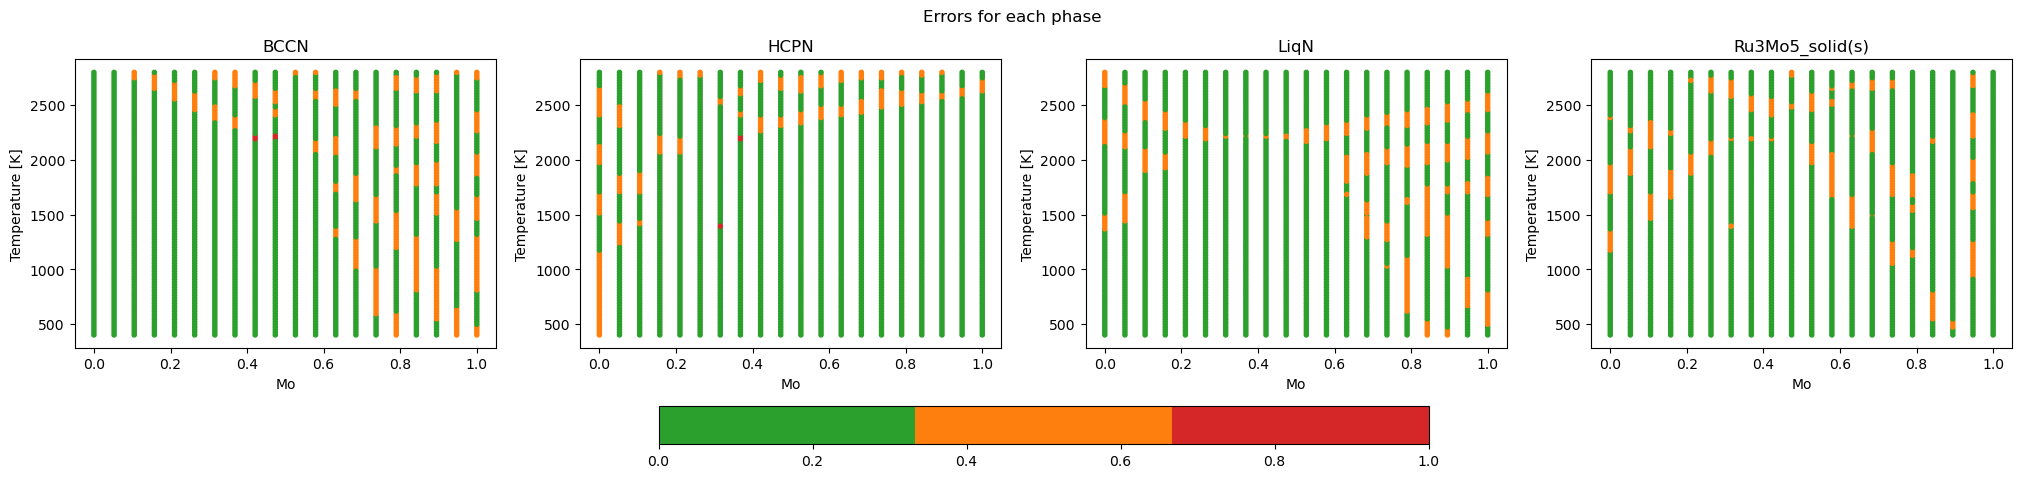

In [47]:
# Errors for each phase

fig, axs = plt.subplots(nrows=1, ncols=len(active_phases), figsize=(25,5))
scatters = []

for i in range(len(active_phases)):
  axs[i].set_xlabel('Mo')
  axs[i].set_ylabel('Temperature [K]')
  axs[i].set_title(active_phases[i])
  scatters.append(axs[i].scatter(X_all_unscaled[:,1].numpy(), X_all_unscaled[:,0].numpy(),
                                 c=errors[:,i],
                                 marker='.',
                                 cmap=colors.ListedColormap(['tab:green', 'tab:orange' ,'tab:red'])))

# Find the min and max of all colors for use in setting the color scale.
vmin = min(scatter.get_array().min() for scatter in scatters)
vmax = max(scatter.get_array().max() for scatter in scatters)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for sc in scatters:
    sc.set_norm(norm)

fig.colorbar(scatters[0], ax=axs, orientation='horizontal', fraction=.1)
fig.suptitle('Errors for each phase')

# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_scatter):
    for sc in scatters:
        if (changed_scatter.get_cmap() != sc.get_cmap()
                or changed_scatter.get_clim() != sc.get_clim()):
            sc.set_cmap(changed_scatter.get_cmap())
            sc.set_clim(changed_scatter.get_clim())

for sc in scatters:
    sc.callbacks.connect('changed', update)

# for i in range(len(active_phases)):
#   ax  = axs[i]
#   ax.set_xlabel('Mo')
#   ax.set_ylabel('T')
#   ax.set_title(active_phases[i])
#   scatter = ax.scatter(X_test_unscaled[:,1].numpy(), X_test_unscaled[:,0].numpy(), c=errors[:,i], marker='.', cmap=colors.ListedColormap(['tab:green', 'tab:orange' ,'tab:red']))
#   fig.colorbar(scatter, orientation='horizontal', ax=ax)


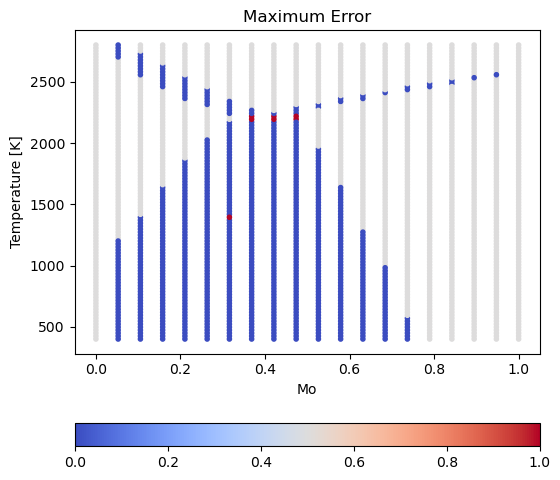

In [48]:
# Combined maximum error

from matplotlib import cm

fig = plt.figure(figsize = (6, 6))
ax = plt.axes()

ax.set_xlabel('Mo')
ax.set_ylabel('Temperature [K]')
ax.set_title('Maximum Error')
ax.scatter(X_all_unscaled[:,1].numpy(), X_all_unscaled[:,0].numpy(), c=errors_combined, marker='.', cmap='coolwarm')
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'), orientation='horizontal', ax=ax)

plt.show()


#### Confidence Level

$$\text{Confidence Level} = \frac{\mu_{\phi_3}}{\mu_{\phi_1}}$$

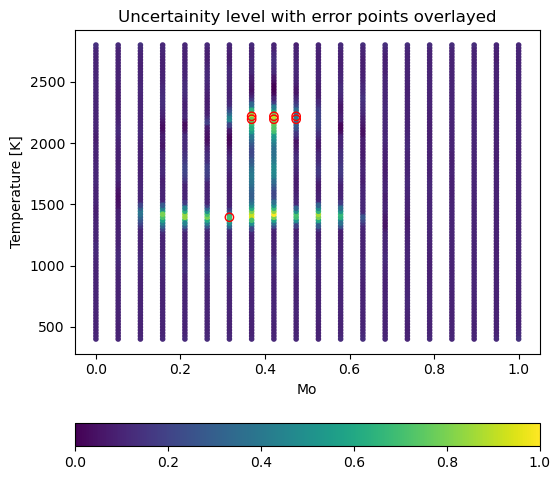

In [49]:
# Points with hard error
error_points = X_all_unscaled[errors_combined == 1.0].numpy().transpose()

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes()

m1 = np.array([m[i] for m,i in zip(means, sorted_indices[:,0])])
m2 = np.array([m[i] for m,i in zip(means, sorted_indices[:,1])])
m3 = np.array([m[i] for m,i in zip(means, sorted_indices[:,2])])

confidence_level = m3/m1

ax.set_xlabel('Mo')
ax.set_ylabel('Temperature [K]')
ax.set_title('Uncertainity level')
ax.scatter(X_all_unscaled[:,1].numpy(), X_all_unscaled[:,0].numpy(), c=confidence_level, marker='.', cmap='viridis')
ax.scatter(error_points[1], error_points[0], facecolors='none', edgecolors='r')
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal')
# ax.set_ylim(1250,2400)

plt.show()


In [ ]:
def fuzz_inputs(x, r):


In [ ]:
def loss_function():
